# Introducción
Este notebook implementa un algoritmo de transferencia de estilo basado en redes neuronales profundas. El objetivo es combinar características de una imagen de contenido con las de una imagen de estilo para generar una nueva imagen estilizada.

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import os
from keras import backend as K
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
from keras.applications import vgg19
from keras.models import Model
#from keras import optimizers
from scipy.optimize import fmin_l_bfgs_b
#from keras.applications.vgg19 import VGG19
#vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
#vgg19 = VGG19(include_top = False, weights=vgg19_weights)
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['image-classification', 'vgg19', 'best-artworks-of-all-time']


# Exploración, Explicación y Limpieza de Datos
El dataset no aplica directamente en este notebook, ya que se procesan imágenes como entradas.
Sin embargo, se realizan transformaciones esenciales, como:


* Escalado de imágenes al tamaño requerido.
* Normalización basada en los valores de los canales RGB de la imagen. Estas preparaciones aseguran que los datos sean aptos para la red neuronal.


In [2]:
StylePath = '../input/best-artworks-of-all-time/images/images/'
ContentPath = '../input/image-classification/validation/validation/travel and adventure/'

## Loading the path for Base Content Image and the Style image respectively

In [3]:
base_image_path = ContentPath+'11.jpg'
style_image_path = StylePath+'Edouard_Manet/Edouard_Manet_10.jpg'

In [4]:
# dimensions of the generated picture.
width, height = load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

In [5]:
def preprocess_image(image_path):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

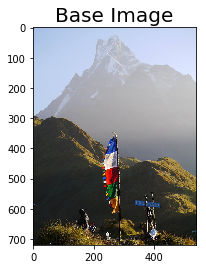

In [6]:
plt.figure()
plt.title("Base Image",fontsize=20)
img1 = load_img(ContentPath+'11.jpg')
plt.imshow(img1)

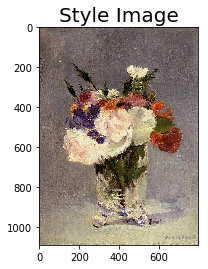

In [7]:
plt.figure()
plt.title("Style Image",fontsize=20)
img1 = load_img(StylePath+'Edouard_Manet/Edouard_Manet_10.jpg')
plt.imshow(img1)

In [8]:
# get tensor representations of our images

base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_image_path))

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
K.image_data_format()

'channels_last'

In [10]:
# this will contain our generated image
if K.image_data_format() == 'channels_first':
    combination_image = K.placeholder((1,3,img_nrows, img_ncols))
else:
    combination_image = K.placeholder((1,img_nrows, img_ncols,3))

In [11]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image
                              ], axis=0)

# Desarrollo del Modelo de Deep Learning
El modelo implementado utiliza una red preentrenada VGG19 para extraer características de estilo y contenido.
Aspectos clave del desarrollo:


* Extracción de características: Se eligen capas específicas de la VGG19 para calcular las pérdidas de contenido y estilo.
  
Funciones de pérdida:

* La pérdida de contenido mide la similitud entre las activaciones de la imagen generada y la imagen de contenido.

* La pérdida de estilo evalúa la correlación entre características de la imagen generada y la imagen de estilo.


* Optimización: Se utiliza el optimizador L-BFGS para mejorar la calidad de la imagen generada. Se justifican estas decisiones basándose en investigaciones previas y la efectividad demostrada de estas técnicas.


In [12]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
from keras.applications.vgg19 import VGG19
vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
model = VGG19(input_tensor=input_tensor,
              include_top = False,
              weights=vgg19_weights)
#model = vgg19.VGG19(input_tensor=input_tensor,
#                    weights='imagenet', include_top=False)
print('Model loaded.')


Model loaded.


In [13]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [14]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
print(outputs_dict['block5_conv2'])

Tensor("block5_conv2/Relu:0", shape=(3, 25, 18, 512), dtype=float32)


In [15]:
# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image
def get_content_loss(base_content, target):
    return K.sum(K.square(target - base_content))

In [16]:
import tensorflow as tf
# the gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(input_tensor):
    assert K.ndim(input_tensor)==3
    #if K.image_data_format() == 'channels_first':
    #    features = K.batch_flatten(input_tensor)
    #else:
    #    features = K.batch_flatten(K.permute_dimensions(input_tensor,(2,0,1)))
    #gram = K.dot(features, K.transpose(features))
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram#/tf.cast(n, tf.float32)

def get_style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return K.sum(K.square(S - C))#/(4.0 * (channels ** 2) * (size ** 2))
    

In [17]:
content_weight=0.025 
style_weight=1.0
# combine these loss functions into a single scalar
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2']
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
print('Layer Feature for Content Layers :: '+str(layer_features))
print('Base Image Feature :: '+str(base_image_features))
print('Combination Image Feature for Content Layers:: '+str(combination_features)+'\n')
loss += content_weight * get_content_loss(base_image_features,
                                      combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    print('Layer Feature for Style Layers :: '+str(layer_features))
    print('Style Image Feature :: '+str(style_reference_features))
    print('Combination Image Feature for Style Layers:: '+str(combination_features)+'\n')
    sl = get_style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl


Layer Feature for Content Layers :: Tensor("block5_conv2/Relu:0", shape=(3, 25, 18, 512), dtype=float32)
Base Image Feature :: Tensor("strided_slice:0", shape=(25, 18, 512), dtype=float32)
Combination Image Feature for Content Layers:: Tensor("strided_slice_1:0", shape=(25, 18, 512), dtype=float32)

Layer Feature for Style Layers :: Tensor("block1_conv1/Relu:0", shape=(3, 400, 300, 64), dtype=float32)
Style Image Feature :: Tensor("strided_slice_2:0", shape=(400, 300, 64), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_3:0", shape=(400, 300, 64), dtype=float32)

Layer Feature for Style Layers :: Tensor("block2_conv1/Relu:0", shape=(3, 200, 150, 128), dtype=float32)
Style Image Feature :: Tensor("strided_slice_6:0", shape=(200, 150, 128), dtype=float32)
Combination Image Feature for Style Layers:: Tensor("strided_slice_7:0", shape=(200, 150, 128), dtype=float32)

Layer Feature for Style Layers :: Tensor("block3_conv1/Relu:0", shape=(3, 100, 75, 256), d

In [18]:
def deprocess_image(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, img_nrows, img_ncols))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [19]:
# get the gradients of the generated image wrt the loss
grads = K.gradients(loss, combination_image)
grads

[<tf.Tensor 'gradients/concat_grad/Slice_2:0' shape=(1, 400, 300, 3) dtype=float32>]

In [20]:
outputs = [loss]
if isinstance(grads, (list,tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = K.function([combination_image], outputs)
f_outputs

In [21]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x_opt = preprocess_image(base_image_path)

In [22]:
def eval_loss_and_grads(x):
    if K.image_data_format() == 'channels_first':
        x = x.reshape((1, 3, img_nrows, img_ncols))
    else:
        x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values


In [23]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [24]:
evaluator = Evaluator()

En este segmento ejecutamos el código hasta una iteración determinada. Aunque no recomiendo utilizar el parámetro **maxiter** en **fmin_l_bfgs_b** para establecer la cantidad de iteraciones. Es mejor utilizar la iteración en un bucle for para obtener mejores resultados


In [25]:
iterations=400
# Store our best result
best_loss, best_img = float('inf'), None
for i in range(iterations):
    print('Start of iteration', i)
    x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                        x_opt.flatten(), 
                                        fprime=evaluator.grads,
                                        maxfun=20,
                                        disp=True,
                                       )
    print('Current loss value:', min_val)
    if min_val < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = min_val
        best_img = x_opt.copy()

Start of iteration 0
Current loss value: 2.9928904e+20
Start of iteration 1
Current loss value: 1.5474446e+20
Start of iteration 2
Current loss value: 1.1151042e+20
Start of iteration 3
Current loss value: 9.119806e+19
Start of iteration 4
Current loss value: 7.877369e+19
Start of iteration 5
Current loss value: 6.7807643e+19
Start of iteration 6
Current loss value: 6.013241e+19
Start of iteration 7
Current loss value: 5.5501016e+19
Start of iteration 8
Current loss value: 4.902536e+19
Start of iteration 9
Current loss value: 4.5077553e+19
Start of iteration 10
Current loss value: 4.1698877e+19
Start of iteration 11
Current loss value: 3.9019024e+19
Start of iteration 12
Current loss value: 3.6972486e+19
Start of iteration 13
Current loss value: 3.5028433e+19
Start of iteration 14
Current loss value: 3.3455405e+19
Start of iteration 15
Current loss value: 3.2042975e+19
Start of iteration 16
Current loss value: 3.0368867e+19
Start of iteration 17
Current loss value: 2.8959667e+19
Start 

**The Final Image**

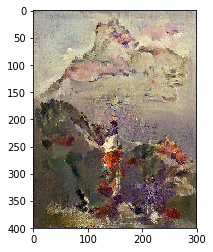

In [26]:
# save current generated image
imgx = deprocess_image(best_img.copy())
plt.imshow(imgx)

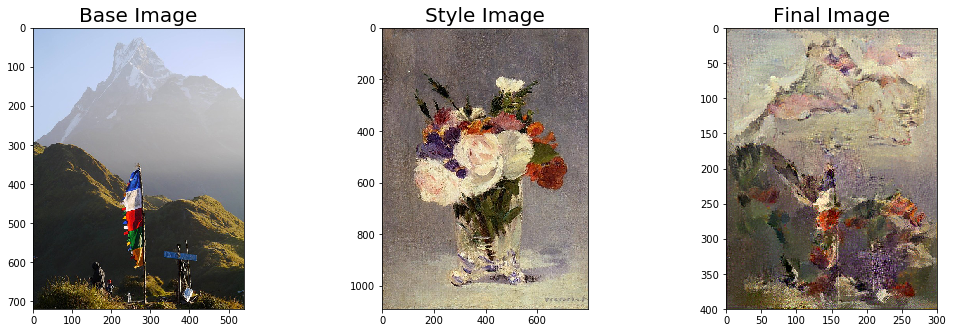

In [27]:
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path)
plt.imshow(img_base)

plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
plt.title("Final Image",fontsize=20)
plt.imshow(imgx)

# Resultados e Interpretación
Se presentan resultados visuales que muestran:


* La comparación entre la imagen original de contenido, la imagen de estilo y la imagen estilizada generada.

* Ajustes realizados durante la optimización, como modificar los pesos de las pérdidas de estilo y contenido, para mejorar la calidad de la transferencia. Se evalúa visualmente la calidad del estilo transferido y cómo los ajustes impactaron los resultados.


In [28]:
def preprocess_image_instantiator(image_path,img_nrows,img_ncols):
    from keras.applications import vgg19
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

In [29]:
def Run_StyleTransfer(base_image_path, style_image_path):
    
    width, height = load_img(base_image_path).size
    img_nrows = 400
    img_ncols = int(width * img_nrows / height)
    
    base_image = K.variable(preprocess_image_instantiator(base_image_path,img_nrows,img_ncols))
    style_reference_image = K.variable(preprocess_image_instantiator(style_image_path,img_nrows,img_ncols))
    
    if K.image_data_format() == 'channels_first':
        combination_image = K.placeholder((1,3,img_nrows, img_ncols))
    else:
        combination_image = K.placeholder((1,img_nrows, img_ncols,3))
        
    input_tensor = K.concatenate([base_image,
                                  style_reference_image,
                                  combination_image
                                  ], axis=0)
    from keras.applications.vgg19 import VGG19
    vgg19_weights = '../input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'
    model = VGG19(input_tensor=input_tensor,
                  include_top = False,
                  weights=vgg19_weights)
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
    
    content_weight=0.025 
    style_weight=1.0
    # combine these loss functions into a single scalar
    loss = K.variable(0.0)
    layer_features = outputs_dict['block5_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    #print('Layer Feature for Content Layers :: '+str(layer_features))
    #print('Base Image Feature :: '+str(base_image_features))
    #print('Combination Image Feature for Content Layers:: '+str(combination_image_features))
    loss += content_weight * get_content_loss(base_image_features,
                                          combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1',
                      'block3_conv1', 'block4_conv1',
                      'block5_conv1']
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        #print('Layer Feature for Style Layers :: '+str(layer_features))
        #print('Style Image Feature :: '+str(style_reference_features))
        #print('Combination Image Feature for Style Layers:: '+str(combination_features))
        sl = get_style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
        
    grads = K.gradients(loss, combination_image)
    
    outputs = [loss]
    if isinstance(grads, (list,tuple)):
        outputs += grads
    else:
        outputs.append(grads)
    f_outputs = K.function([combination_image], outputs)
    
    x_opt = preprocess_image(base_image_path)
    
    evaluator = Evaluator()
    iterations=200
    # Store our best result
    best_loss, best_img = float('inf'), None
    for i in range(iterations):
        #print('Start of iteration', i)
        x_opt, min_val, info= fmin_l_bfgs_b(evaluator.loss, 
                                            x_opt.flatten(), 
                                            fprime=evaluator.grads,
                                            maxfun=20,
                                            disp=True,
                                           )
        #print('Current loss value:', min_val)
        if min_val < best_loss:
            # Update best loss and best image from total loss. 
            best_loss = min_val
            best_img = x_opt.copy()
    imgx = deprocess_image(best_img.copy())
    
    return imgx

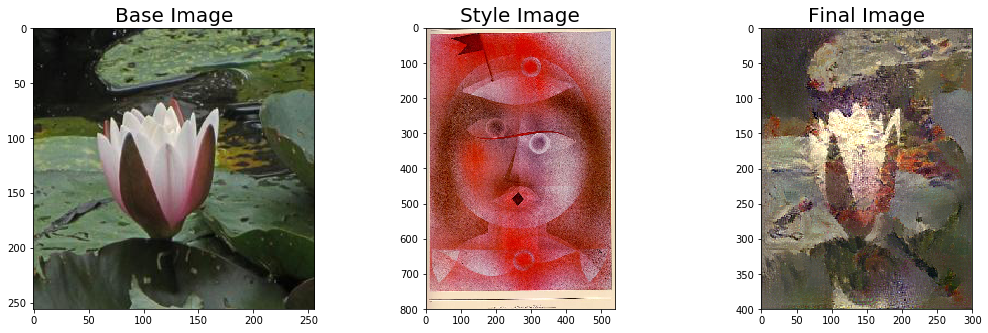

In [33]:
base_image_path_1 = '../input/image-classification/images/images/travel and  adventure/Places365_val_00005821.jpg'
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path_1)
plt.imshow(img_base)

style_image_path_1 = '../input/best-artworks-of-all-time/images/images/Paul_Klee/Paul_Klee_96.jpg'
plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path_1)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
imgg = Run_StyleTransfer(base_image_path_1, style_image_path_1)
plt.title("Final Image",fontsize=20)
plt.imshow(imgg)

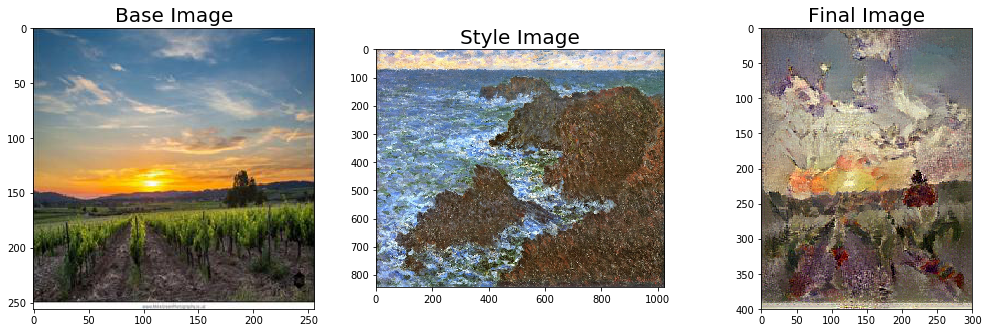

In [34]:
base_image_path_2 = '../input/image-classification/images/images/travel and  adventure/Places365_val_00005737.jpg'
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path_2)
plt.imshow(img_base)

style_image_path_2 = '../input/best-artworks-of-all-time/images/images/Claude_Monet/Claude_Monet_11.jpg'
plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path_2)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
imga = Run_StyleTransfer(base_image_path_2, style_image_path_2)
plt.title("Final Image",fontsize=20)
plt.imshow(imga)

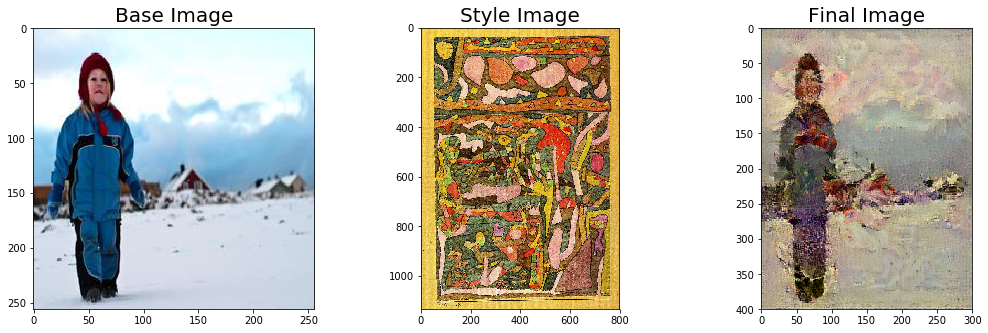

In [35]:
base_image_path_3 = '../input/image-classification/images/images/travel and  adventure/Places365_val_00005752.jpg'
plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
plt.title("Base Image",fontsize=20)
img_base = load_img(base_image_path_3)
plt.imshow(img_base)

style_image_path_3 = '../input/best-artworks-of-all-time/images/images/Paul_Klee/Paul_Klee_83.jpg'
plt.subplot(5,5,1+1)
plt.title("Style Image",fontsize=20)
img_style = load_img(style_image_path_3)
plt.imshow(img_style)

plt.subplot(5,5,1+2)
imgy = Run_StyleTransfer(base_image_path_3, style_image_path_3)
plt.title("Final Image",fontsize=20)
plt.imshow(imgy)

# Conclusión

El modelo demuestra la capacidad de combinar características de imágenes de contenido y estilo de manera efectiva.

Observaciones clave:


* Los resultados dependen significativamente de la selección de capas de pérdida y los parámetros de optimización.
* Ajustar hiperparámetros es esencial para obtener imágenes estilizadas de alta calidad. Esto demuestra el potencial y los desafíos de los algoritmos de transferencia de estilo.
